# Lab3: Clustering with K-means, K-means++ and Kmedioids

## Overview
In this lab, you will learn how to implement and analyze the **K-means**, **K-means++**  and **Kmedioids** clustering algorithms on two different real-world datasets:

- **MNIST Digits** (10 handwritten digits (image)).  
- **CIFAR-10 dataset** (different categories of imagenet style objects).  

You will compare the performance of **K-means**,  **K-means++** and **Kmedioids**.

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**. 


In [2]:
# Install dependencies if needed
#!pip install datasets scikit-learn matplotlib numpy seaborn pandas
#!pip install kmedoids

from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import kmedoids
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
from collections import Counter
from sklearn.manifold import TSNE



c:\Users\eadun\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset MNIST (HandWritten Digits)

c:\Users\eadun\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\eadun\.cache\huggingface\hub\datasets--mnist. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 703742.28 examples/s]


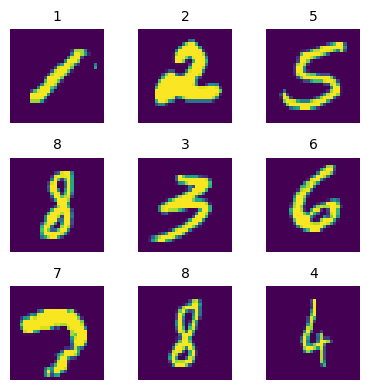

In [ ]:
# 1. Load MNIST dataset

dataset = load_dataset("mnist", split="train[:5000]")
dataset = dataset.shuffle(seed=42) # random seed, must be fixed for reproducibility

fig, axes = plt.subplots(3, 3, figsize=(4, 4)) # 3x3 grid, 4x4 inches

for i, ax in enumerate(axes.flat): # flatten the 3x3 grid to a list of 9 axes
    img = dataset[i]["image"] # get the image
    label = dataset.features["label"].int2str(dataset[i]["label"])  # get the label
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [4]:
# 2. Preprocess: resize + flatten images

X = np.array([np.array(img.resize((64, 64))).flatten() # resize to 64x64 and flatten
              for img in dataset["image"]], dtype=np.float32) 
X = X / 255.0  # normalize to [0, 1]

print("Data shape:", X.shape)  # (N, 64*64*3)


# Reduce to 50 dimensions (you can tune this number)
pca = PCA(n_components=786, random_state=42)
X = pca.fit_transform(X)


# 3. Extract labels

y = np.array(dataset["label"])
label_names = dataset.features["label"].names

print("Labels shape:", y.shape)

# 4. Count unique clusters

unique_labels, counts = np.unique(y, return_counts=True)
n_classes = len(unique_labels)

print("\nNumber of unique clusters (classes):", n_classes)
print("Allclasses:")
for i in range(n_classes):
    print(f"{unique_labels[i]} -> {label_names[unique_labels[i]]} ({counts[i]} samples)")


Data shape: (5000, 4096)
Labels shape: (5000,)

Number of unique clusters (classes): 10
Allclasses:
0 -> 0 (479 samples)
1 -> 1 (563 samples)
2 -> 2 (488 samples)
3 -> 3 (493 samples)
4 -> 4 (535 samples)
5 -> 5 (434 samples)
6 -> 6 (501 samples)
7 -> 7 (550 samples)
8 -> 8 (462 samples)
9 -> 9 (495 samples)


In [7]:
#This is a helper function that will help you visualize the top 5 datapoints in each cluster
def show_closest_images(X, dataset, centroids, labels, title, num_images=5): # Visualize closest images to centroids
    n_clusters = len(centroids)
    fig, axes = plt.subplots(n_clusters, num_images, figsize=(1.2*num_images, 1.2*n_clusters))


    # If only 1 cluster, fix axes shape
    if n_clusters == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, centroid in enumerate(centroids):
        distances = np.linalg.norm(X - centroid, axis=1)
        cluster_indices = np.where(labels == i)[0]

        if len(cluster_indices) == 0:
            continue 

        closest_indices = cluster_indices[np.argsort(distances[cluster_indices])[:num_images]]

        for j, idx in enumerate(closest_indices):
            try:
                img = dataset[int(idx)]["image"]
            except:
                img = dataset[int(idx)]["img"]
            label_name = dataset.features["label"].int2str(dataset[int(idx)]["label"])

            axes[i, j].imshow(img)
            axes[i, j].axis("off")

            axes[i, j].text(0.5, -0.15, label_name,
                            size=7, ha="center", va="top", transform=axes[i, j].transAxes)

            if j == 0:
                axes[i, j].set_title(f"Cluster {i}", fontsize=9)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# [TODO] Implement KMeans for MNIST (2 points)

## Instructions

In this section, you will implement **K-means** using the **sklearn** library.

- Use the `KMeans` class from `sklearn.cluster`. 
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to another value **you will not get full score**. 

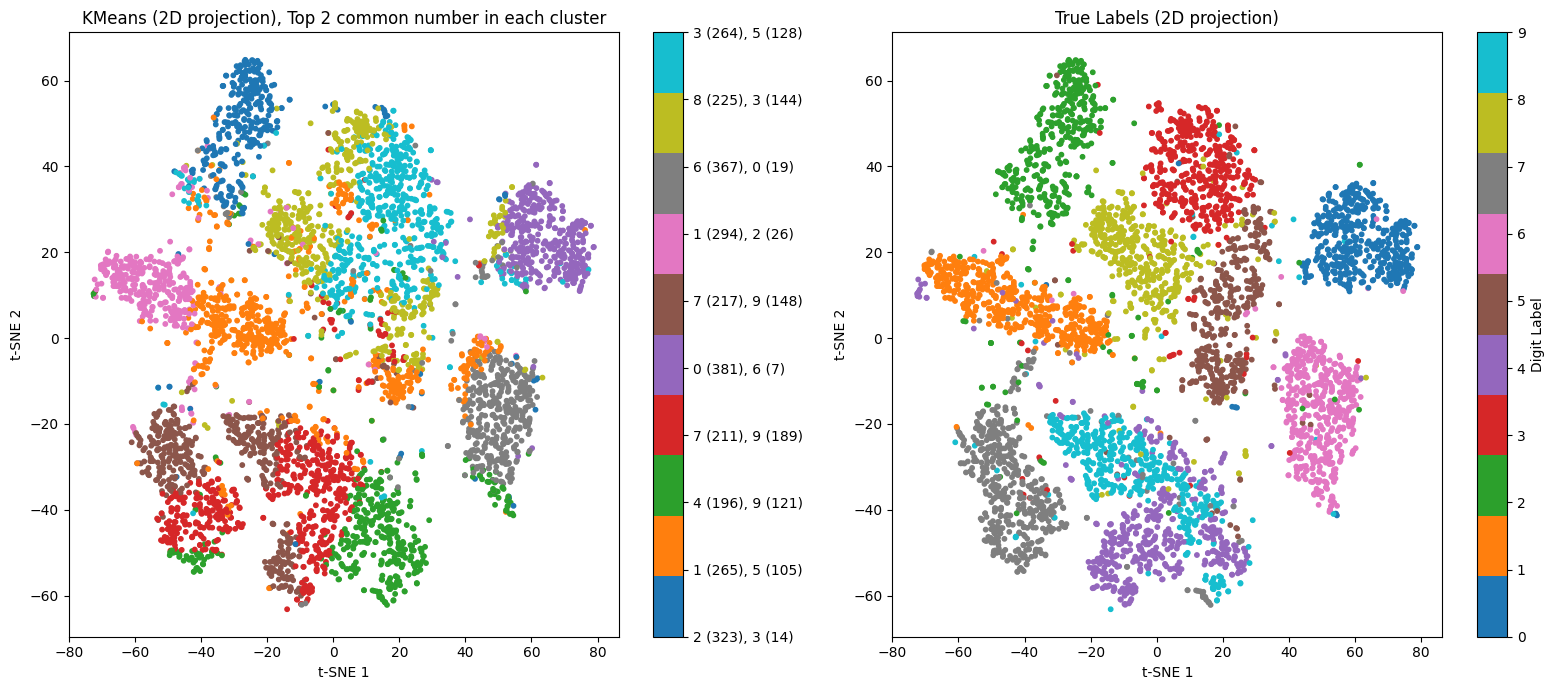

In [14]:
# ----------------------------
# TODO Implement KMeans
# ----------------------------
from sklearn.cluster import KMeans

k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=50, random_state=42).fit(X)
labels_km = kmeans.labels_
centroids_km = kmeans.cluster_centers_

# ----------------------------
# Implemenetation ends here 
# ----------------------------

# Reduce to 2D for visualization
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)


tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_km == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_km, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()




# [TODO]: Find Confused Digit Pairs in Kmeans (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pairs (most common, second most common) and write your answer here. 

Answer: [TODO]


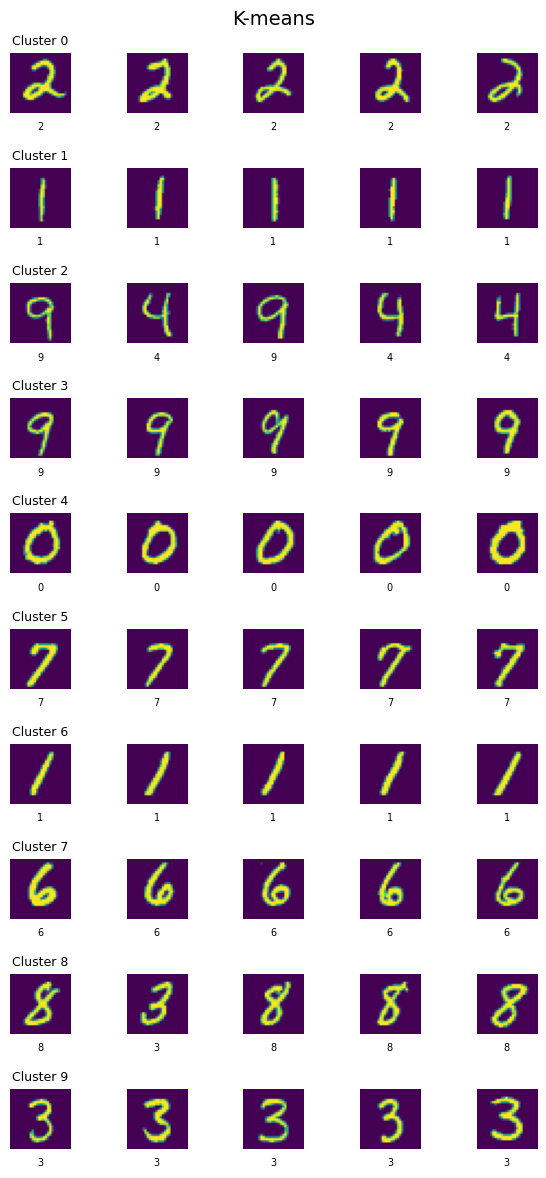

In [ ]:
show_closest_images(X, dataset, centroids_km, labels_km, "K-means")

# check second most common true label for each cluster:
for cluster_id in range(k):
    idxs = np.where(labels_km == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
            print(f"Cluster {cluster_id}: ", end="")
            for label, count in counts:
                print(f"{label} ({count}) ", end="")
            print()
    else:
        print(f"Cluster {cluster_id}: Empty")

# [TODO] Implement KMeans++ for MNIST (2 points)

## Instructions

In this section, you will implement **K-means ++** using the **sklearn** library.

- Use the `KMeans` class from `sklearn.cluster`. 
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans ++ ?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**. 

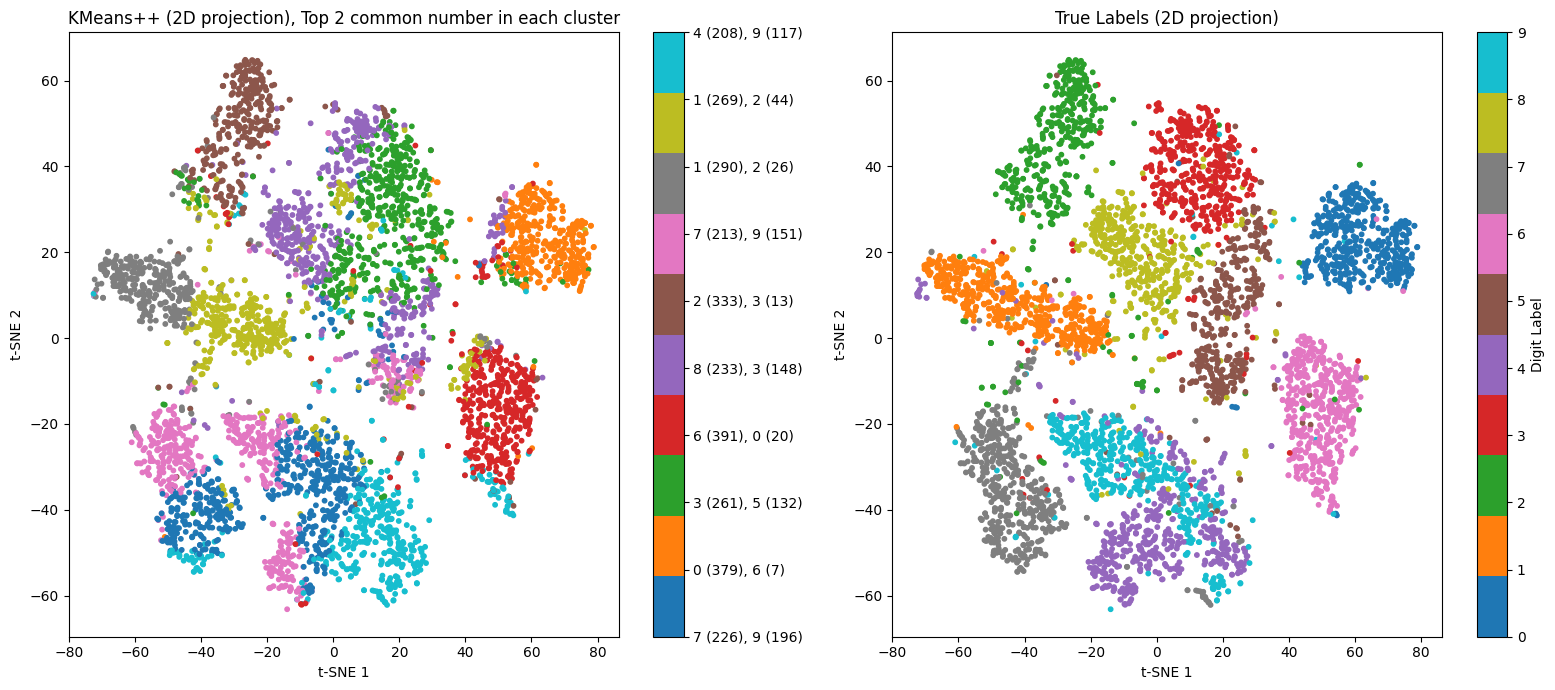

In [20]:
# ----------------------------
# TODO Implement Kmeans ++
# ----------------------------
from sklearn.cluster import KMeans

k = 10  # Number of clusters
kmeans_pp = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=50, random_state=42).fit(X)
labels_pp = kmeans_pp.labels_
centroids_pp = kmeans_pp.cluster_centers_

# ----------------------------
# Implemenetation ends here 
# ----------------------------

# Reduce to 2D for visualization
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)


tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_pp == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_pp, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans++ (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()



# [TODO]: Find Confused Digit Pairs  in Kmeans++ (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pair (most common, second most common) and write your answer here. 

Answer: [TODO]

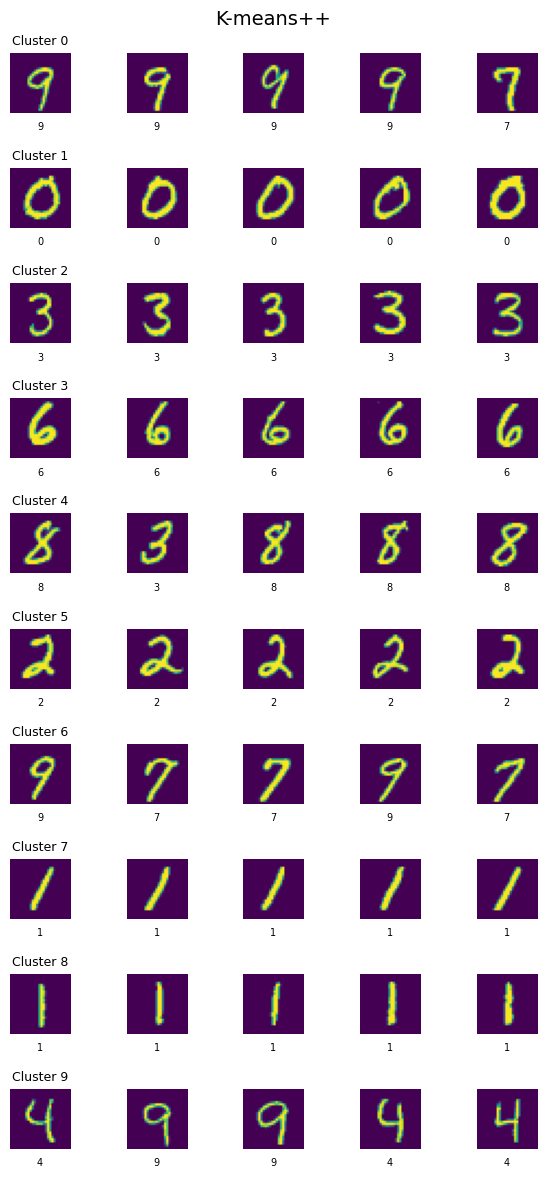

Cluster 0: 7 (226) 9 (196) 
Cluster 1: 0 (379) 6 (7) 
Cluster 2: 3 (261) 5 (132) 
Cluster 3: 6 (391) 0 (20) 
Cluster 4: 8 (233) 3 (148) 
Cluster 5: 2 (333) 3 (13) 
Cluster 6: 7 (213) 9 (151) 
Cluster 7: 1 (290) 2 (26) 
Cluster 8: 1 (269) 2 (44) 
Cluster 9: 4 (208) 9 (117) 


In [21]:
show_closest_images(X, dataset, centroids_pp, labels_pp, "K-means++")

# check second most common true label for each cluster:
for cluster_id in range(k):
    idxs = np.where(labels_pp == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        print(f"Cluster {cluster_id}: ", end="")
        for label, count in counts:
            print(f"{label} ({count}) ", end="")
        print()
    else:
        print(f"Cluster {cluster_id}: Empty")

# [TODO] Implement Kmedioids (2 points)

## Instructions 
KMedoids (with `kmedoids` package)

- Use the `KMedoids` class from the **`kmedoids`** package, which you must have pip installed at the start of the notebook.  
- Set the following parameters:
  - `n_clusters = k` → number of clusters (choose based on dataset).  
  - `method = "fasterpam"` → efficient implementation of the PAM algorithm.  
  - `metric = "precomputed"` → pass a precomputed distance matrix.  
  - `random_state = 42` → ensures reproducibility.  
Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**. 

Extra Note:  Before running KMedoids, you need to compute a **distance matrix** using e.g.  
  ```python
dist_matrix = pairwise_distances(X, metric="manhattan")



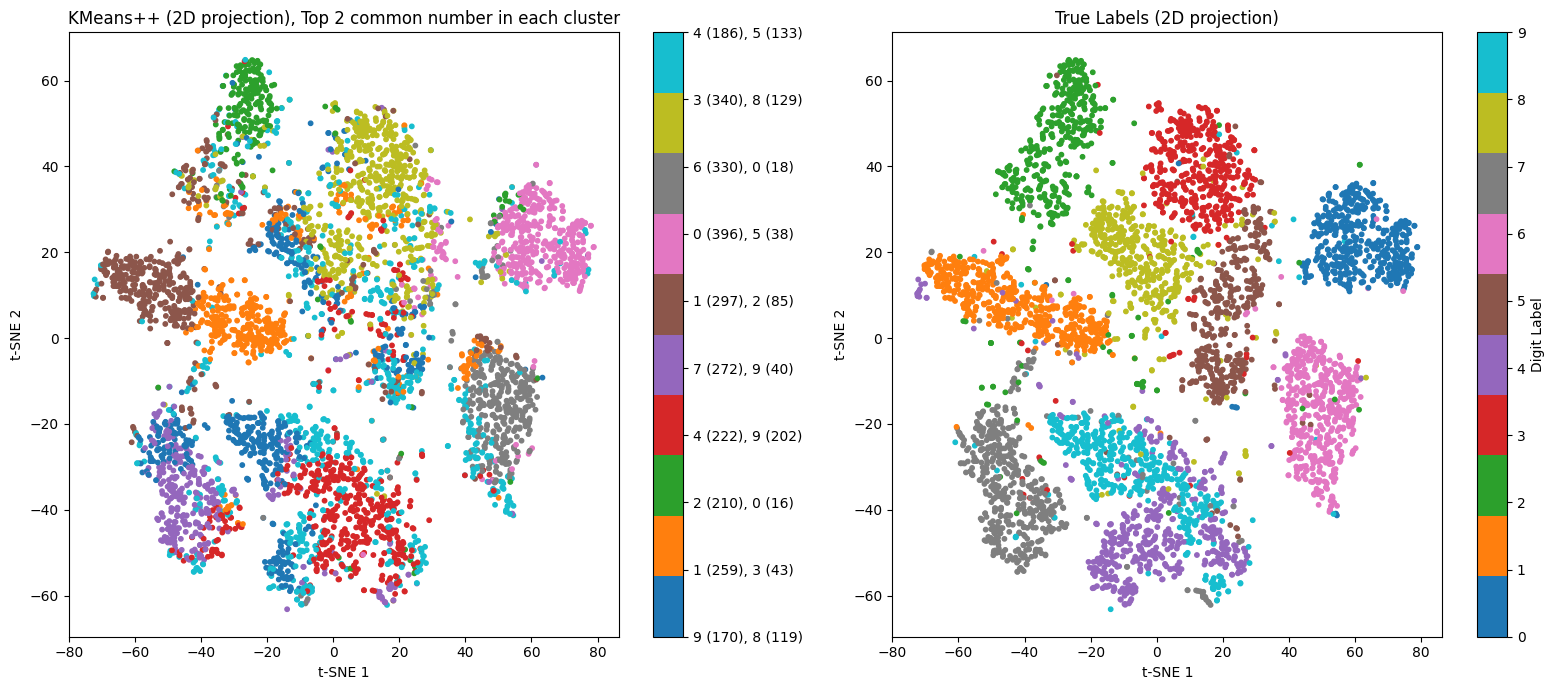

In [22]:
# -------------------------
# TODO Implement KMedoids
# ------------------------
from kmedoids import KMedoids

distance_matrix = pairwise_distances(X, metric='euclidean')

k = 10  # Number of clusters
kmedoids_instance = KMedoids(n_clusters=k, method='fasterpam', metric='precomputed', random_state=42)
labels_kmed = kmedoids_instance.fit_predict(distance_matrix)
centroids_kmed = X[kmedoids_instance.medoid_indices_]


# ----------------------------
# Implementation ends here
# ----------------------------

# Reduce to 2D for visualization
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)


tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_kmed == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmed, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans++ (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()




# [TODO] Find Confused Digit Pairs  in Kmedioids (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pair (most common, second most common) and write your answer here. 

Answer: [TODO]

# [TODO] Compute Silhouette scores for MNIST (2 points)

In [23]:

# -------------------------------------------------------------------------------------
# TODO Implement Metrics: Compute Silhouette scores for Kmeans, Kmeans++ and Kmedioids
# --------------------------------------------------------------------------------------

from sklearn.metrics import silhouette_score

sil_km_rand = silhouette_score(X, labels_km)
sil_km_pp = silhouette_score(X, labels_pp)
sil_kmed = silhouette_score(X, labels_kmed)


# ----------------------------
# Implemenetation ends here 
# ----------------------------

results = pd.DataFrame({
    "Algorithm": ["KMeans", "KMeans++", "KMedoids"],
    "Silhouette Score": [sil_km_rand, sil_km_pp, sil_kmed]
})
results



,Algorithm,Silhouette Score
0,KMeans,0.071394
1,KMeans++,0.069799
2,KMedoids,0.064421


# [TODO] Using the Silhouette scores answer which method is doing better? (1 point)


Answer: KMeans has the highest silhouette score, so by that metric it has the best performance for clustering.

# Clustering a pixels in a Single Image

## [TODO] Image Clustering with KMeans and KMeans++ (2 points)

In this exercise, you will explore how clustering can be applied to images.  
Instead of clustering entire datasets, we cluster the **pixels** of an image based on their RGB values.  

Instructions for Kmeans:

- Use the `KMeans` class from `sklearn.cluster`. 
- Set the following parameters:
  - `n_clusters = k` (set this to 5).  
  - `init = "?"` what should this be for Kmeans?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Instructions for Kmeans ++

- Use the `KMeans` class from `sklearn.cluster`. 
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans ++ ?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility). 

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to another value **you will not get full score**. 

Image shape: (566, 904, 4)
Pixels shape: (511664, 4)


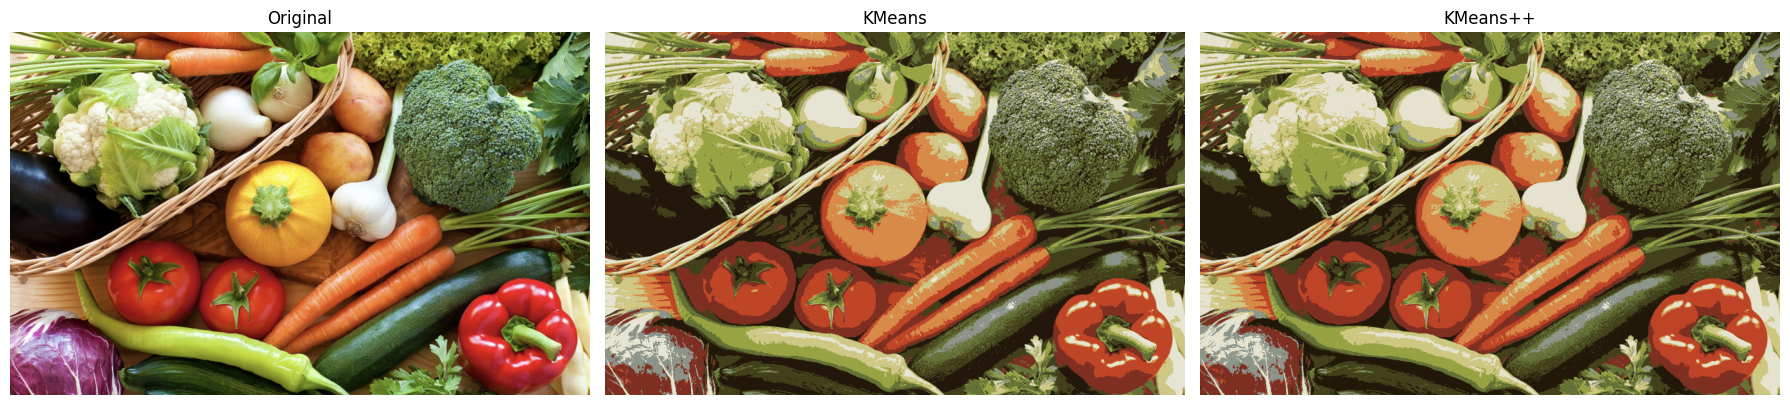

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from skimage.io import imread
from skimage.transform import rescale
import kmedoids


image = imread("image0.png")   
image = rescale(image, 0.5, channel_axis=-1)  

image_shape = image.shape
pixels = image.reshape(-1, image_shape[-1])
print("Image shape:", image_shape)
print("Pixels shape:", pixels.shape)
k = 10  # Number of colors

# ------------------------------------------------------------
# TODO Implement KMeans 
# ------------------------------------------------------------

quantized_rand = KMeans(n_clusters=k, init='random', n_init=10, max_iter=50, random_state=42).fit(pixels)
quantized_rand = quantized_rand.cluster_centers_[quantized_rand.labels_]
quantized_rand = quantized_rand.reshape(image_shape)

# ----------------------------------------------
# Implement Kmeans ++
# ----------------------------------------------
   
quantized_pp = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=50, random_state=42).fit(pixels)
quantized_pp = quantized_pp.cluster_centers_[quantized_pp.labels_]
quantized_pp = quantized_pp.reshape(image_shape)

# ------------------------------------------------------------
# Implementation Ends here
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(quantized_rand)
axes[1].set_title("KMeans")
axes[1].axis("off")

axes[2].imshow(quantized_pp)
axes[2].set_title("KMeans++")
axes[2].axis("off")


plt.tight_layout()
plt.show()





## [TODO] Image Clustering (Instructions) (10 points)
1. Load each of the three images which should be given to you (image1.jpg, image2.jpg, image3.jpg)
2. For each image, apply **KMeans clustering** twice:  
   - **KMeans (Random Init)**  
   - **KMeans++ (Smart Init)**  
3. Replace each pixel with the color of its cluster centroid.  
   - This reduces the number of unique colors in the image.  
   - The result is a “posterized” image with simplified colors.  
4. Display the results in a **3×3 grid**:  
   - **Column 1** → Original images.  
   - **Column 2** → KMeans results.  
   - **Column 3** → KMeans++ results.  

You need to get the output as follows: 
- A single figure with 9 panels (3 rows × 3 columns).  
- Each row corresponds to one image.  
- The leftmost image in each row is the original, followed by its KMeans and KMeans++ clustered versions.  
---


In [25]:

from skimage.io import imread

def cluster_image(image_path, k=5):
    image = imread(image_path)
    image = rescale(image, 0.5, channel_axis=-1)  
    h, w, c = image.shape
    pixels = image.reshape(-1, c)


    # ----------------------------------------------
    # Implement Kmeans 
    # ----------------------------------------------
    kmeans_image = KMeans(n_clusters=k, init='random', n_init=10, max_iter=50, random_state=42).fit(X)
    # ----------------------------------------------
    # Implement Kmeans ++
    # ----------------------------------------------
    kmeans_pp_image = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=50, random_state=42).fit(X)
    # ----------------------------------------------
    # Implementation ends here 
    # ----------------------------------------------

    return image, kmeans_image, kmeans_pp_image


images = ["image1.jpg", "image2.jpg", "image3.jpg"]
results = [cluster_image(img, k=6) for img in images]


fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, (orig, km_rand, km_pp) in enumerate(results):
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title(f"Original {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(km_rand)
    axes[i, 1].set_title(f"KMeans {i+1}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(km_pp)
    axes[i, 2].set_title(f"KMeans++ {i+1}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()



ModuleNotFoundError: No module named 'skimage'

# [TODO] Answer the following questions (8 points)

---

**1. Question:** What does the Silhouette Score of KMeans++ for MNIST dataset represent?  

**Answer:**  


---

**2. Question:** When you used the KMeans library you set `n_init = 10`. What does `n_init` do?  

**Answer:**  


---

**3. Question:** When you used the KMeans library you set `max_iter = 50`. What does `max_iter` do?  

**Answer:**  


---

**4. Question:** What distance metric did you use for computing the Silhouette score of KMedoids?  

**Answer:**  


---
